In [1]:
from syne_tune import Tuner, StoppingCriterion
from syne_tune.backend import PythonBackend
from syne_tune.config_space import randint, uniform, loguniform
from syne_tune.optimizer.baselines import CQR
from syne_tune.experiments import load_experiment


Ontix checks:
All possible feature names length: 7340
Feature order length: 8617
Features in feature_order not found in all_feature_names: ['ENSG00000186092', 'ENSG00000188157', 'ENSG00000186891', 'ENSG00000186827', 'ENSG00000175756', 'ENSG00000242485', 'ENSG00000248333', 'ENSG00000008128', 'ENSG00000169885', 'ENSG00000142611', 'ENSG00000187017', 'ENSG00000215788', 'ENSG00000049249', 'ENSG00000197241', 'ENSG00000049239', 'ENSG00000142657', 'ENSG00000175206', 'ENSG00000083444', 'ENSG00000120949', 'ENSG00000162496', 'ENSG00000189337', 'ENSG00000162438', 'ENSG00000142615', 'ENSG00000215695', 'ENSG00000117122', 'ENSG00000159363', 'ENSG00000179051', 'ENSG00000009709', 'ENSG00000162482', 'ENSG00000053371', 'ENSG00000158747', 'ENSG00000075151', 'ENSG00000142798', 'ENSG00000219073', 'ENSG00000070886', 'ENSG00000133216', 'ENSG00000011009', 'ENSG00000158006', 'ENSG00000131914', 'ENSG00000090273', 'ENSG00000130772', 'ENSG00000180198', 'ENSG00000060656', 'ENSG00000162510', 'ENSG00000084636', 'ENSG

/home/ewald/Github/autoencodix_package/src/autoencodix/visualize/_general_visualizer.py:34: UserWarning: Model weights plot is skipped since input dimension 8617 is larger than 3000 and heatmap would be too large.
  warnings.warn(


Perform ML task with feature df: Latent
Latent
Perform ML task for target parameter: cell_type


/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classes in split valid are not present in training data
Classes in split test are not present in training data
Perform ML task for target parameter: tissue


/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Perform ML task for target parameter: development_stage


/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Perform ML task for target parameter: sex
Average ML Task Performance: 0.8000012915542309, Valid Recon Loss: 730.63051199262


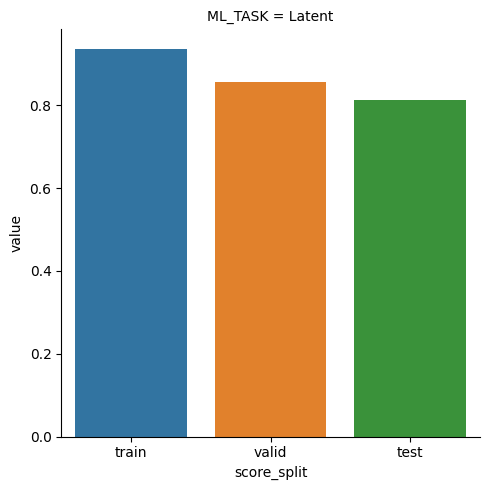

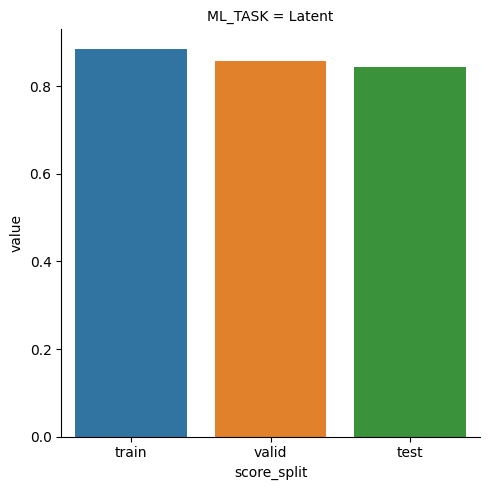

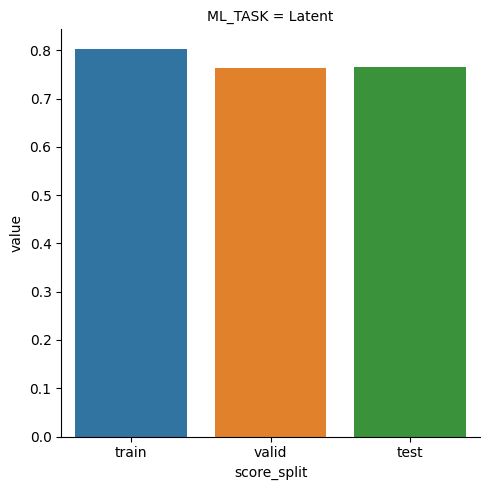

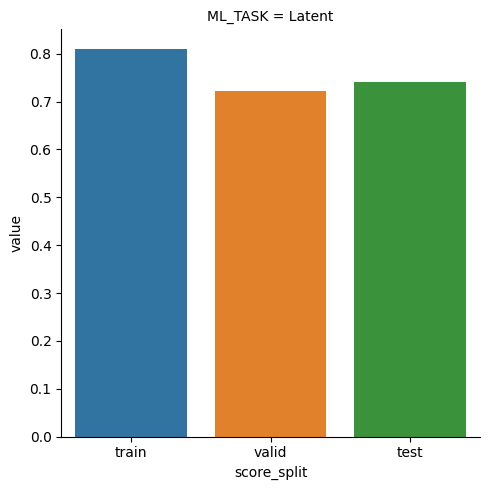

In [31]:
## Load Dataset Container from pickle with already preprocessed data
import pickle
import sklearn
from sklearn import linear_model
import autoencodix as acx
from autoencodix.configs.ontix_config import OntixConfig
from syne_tune import Reporter

file_pkl = "./large_sc_data/large-ontix-processed-data.pkl"
epochs = 5
checkpoint_interval = 5
batch_size = 512
drop_p = 0.1
enc_factor = 2
weight_decay = 1e-2
beta = 0.1
learning_rate = 1e-3
n_layers = 2
loss_reduction = "sum"
ontology_name = "chatgpt_ontology__"
tasks = "$".join(["cell_type", "tissue", "development_stage", "sex"]) ## Include disease later when available


with open(file_pkl, "rb") as f:
	acx_container = pickle.load(f)

scconfig = OntixConfig(
	## Fixed params
	epochs=epochs,
	checkpoint_interval= checkpoint_interval,
	loss_reduction= loss_reduction,
	## Tunable params
	batch_size= batch_size,
	drop_p= drop_p,
	enc_factor= enc_factor,
	weight_decay= weight_decay,
	beta= beta,
	learning_rate= learning_rate,
	n_layers= n_layers,
)


ont_files = [
	# Order from Latent Dim -> Hidden Dim -> Input Dim
	f"./llm_ontologies/{ontology_name}ensembl_level1.tsv",
	f"./llm_ontologies/{ontology_name}ensembl_level2.tsv",
	]

ontix = acx.Ontix(
	data=acx_container,
	ontologies=ont_files,
	config=scconfig
	)

ontix.run()

## Embedding Evaluation
sklearn.set_config(enable_metadata_routing=True)

sklearn_ml_class = linear_model.LogisticRegression(
							solver="sag",
							n_jobs=-1,
							class_weight="balanced",
							max_iter=200,
) 
sklearn_ml_regression = linear_model.LinearRegression() ## Unused, only classification tasks
own_metric_class = 'roc_auc_ovo'  
own_metric_regression = 'r2' 

tasks_list = tasks.split("$")
ontix.evaluate(
	ml_model_class=sklearn_ml_class, 
	ml_model_regression=sklearn_ml_regression, 
	params= tasks_list,	
	metric_class = own_metric_class, 
	metric_regression = own_metric_regression, 
	reference_methods = [], # No reference methods for tuning
	split_type = "use-split",
	n_downsample = int(acx_container.train.data.shape[0]*0.5), # Use a subset of the data for faster evaluation
)

avg_mltask_performance = ontix.result.embedding_evaluation.loc[
	ontix.result.embedding_evaluation.score_split == "valid",
	"value"
].mean()
valid_recon_loss = ontix.result.sub_losses.get("recon_loss").get(epoch=-1, split="valid")
print(f"Average ML Task Performance: {avg_mltask_performance}, Valid Recon Loss: {valid_recon_loss}")

In [37]:
def syne_trainer(
	## Fixed params
	epochs: int,
	checkpoint_interval: int,
	loss_reduction: str,
	data_path: str,
	ontology_name: str,
	tasks: str,
	## Tunable params
	batch_size: int,
	drop_p: float,
	enc_factor: int,
	weight_decay: float,
	beta: float,
	learning_rate: float,
	n_layers: int,
):
	## Load Dataset Container from pickle with already preprocessed data
	import pickle
	import sklearn
	from sklearn import linear_model
	import autoencodix as acx
	from autoencodix.configs.ontix_config import OntixConfig
	from syne_tune import Reporter
	
	file_pkl = data_path

	with open(file_pkl, "rb") as f:
		acx_container = pickle.load(f)

	scconfig = OntixConfig(
		## Fixed params
		epochs=epochs,
		checkpoint_interval= checkpoint_interval,
		loss_reduction= loss_reduction,
		## Tunable params
		batch_size= batch_size,
		drop_p= drop_p,
		enc_factor= enc_factor,
		weight_decay= weight_decay,
		beta= beta,
		learning_rate= learning_rate,
		n_layers= n_layers,
	)


	ont_files = [
		# Order from Latent Dim -> Hidden Dim -> Input Dim
		f"./llm_ontologies/{ontology_name}ensembl_level1.tsv",
		f"./llm_ontologies/{ontology_name}ensembl_level2.tsv",
		]

	ontix = acx.Ontix(
		data=acx_container,
		ontologies=ont_files,
		config=scconfig
		)

	ontix.run()

	## Embedding Evaluation
	sklearn.set_config(enable_metadata_routing=True)

	sklearn_ml_class = linear_model.LogisticRegression(
								solver="sag",
								n_jobs=-1,
								class_weight="balanced",
								max_iter=200,
	) 
	sklearn_ml_regression = linear_model.LinearRegression() ## Unused, only classification tasks
	own_metric_class = 'roc_auc_ovo'  
	own_metric_regression = 'r2' 

	tasks_list = tasks.split("$")
	ontix.evaluate(
		ml_model_class=sklearn_ml_class, 
		ml_model_regression=sklearn_ml_regression, 
		params= tasks_list,	
		metric_class = own_metric_class, 
		metric_regression = own_metric_regression, 
		reference_methods = [], # No reference methods for tuning
		split_type = "use-split",
		n_downsample = int(acx_container.train.data.shape[0]*0.5), # Use a subset of the data for faster evaluation
	)

	avg_mltask_performance = ontix.result.embedding_evaluation.loc[
		ontix.result.embedding_evaluation.score_split == "valid",
		"value"
	].mean()
	valid_recon_loss = float(ontix.result.sub_losses.get("recon_loss").get(epoch=-1, split="valid"))

	report = Reporter()
	report(ml_performance=avg_mltask_performance, recon_loss=valid_recon_loss)

	# return avg_mltask_performance, valid_recon_loss

In [ ]:
tasks = ["cell_type", "tissue", "development_stage", "sex"] ## Include disease later when available
ontology_name = "chatgpt_ontology__"
file_pkl = "./large_sc_data/large-ontix-processed-data.pkl"

# Hyperparameter configuration space
config_space = {
	## Fixed params
	"epochs": 5,
	"checkpoint_interval": 100,
	"loss_reduction": "sum",
	"data_path": file_pkl,
	"ontology_name": ontology_name,
	"tasks": "$".join(tasks),
	## Tunable params
	"batch_size": randint(32, 512),
	"drop_p": uniform(0.0, 0.9),
	"enc_factor": randint(1, 5),
	"weight_decay": loguniform(1e-5, 1e-1),
	"beta": loguniform(1e-5, 10),
	"learning_rate": loguniform(1e-5, 1e-1),
	"n_layers": randint(2, 5),
}

metric = "ml_performance"
# metric = "recon_loss"
if metric == "ml_performance":
	do_minimize = False
elif metric == "recon_loss":
	do_minimize = True
else:
	do_minimize = False

# Scheduler (i.e., HPO algorithm)
scheduler = CQR(
    config_space,
    metric=metric,
    do_minimize=do_minimize
)

tuner = Tuner(
    trial_backend=PythonBackend(tune_function=syne_trainer, config_space=config_space),
    scheduler=scheduler,
    stop_criterion=StoppingCriterion(
		# max_wallclock_time=180,  # in seconds
		max_num_trials_completed=2,
		),
    n_workers=2,  # how many trials are evaluated in parallel
)


In [39]:
tuner.run()

tuning_experiment = load_experiment(tuner.name)

print(f"best result found: {tuning_experiment.best_config()}")

tuning_experiment.plot()

--------------------
Resource summary (last result is reported):
 trial_id     status  iter  epochs  checkpoint_interval loss_reduction                                      data_path      ontology_name                                  tasks  batch_size   drop_p  enc_factor  weight_decay     beta  learning_rate  n_layers  ml_performance  recon_loss  worker-time
        0  Completed     1       5                  100            sum ./large_sc_data/large-ontix-processed-data.pkl chatgpt_ontology__ cell_type$tissue$development_stage$sex         490 0.748499           2      0.003490 0.030251       0.003559         2        0.695948  632.599297     0.000009
        1 InProgress     0       5                  100            sum ./large_sc_data/large-ontix-processed-data.pkl chatgpt_ontology__ cell_type$tissue$development_stage$sex         150 0.495050           1      0.000543 0.000093       0.000795         2               -           -            -
        2  Completed     1       5       

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/syne_tune/experiments/experiment_result.py:138: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [21]:
## Save the tuning experiment
import pickle

with open("./large_ontix_save/large_ontix_syne_tune_experiment.pkl", "wb") as f:
	pickle.dump(tuning_experiment, f)


In [11]:
## Load the tuning experiment

import pickle

with open("./large_ontix_save/large_ontix_syne_tune_experiment_mltask.pkl", "rb") as f:
# with open("./large_ontix_save/large_ontix_syne_tune_experiment_recon.pkl", "rb") as f:
	tuning_experiment = pickle.load(f)

tuning_experiment

ExperimentResult(name='python-entrypoint-2025-10-13-14-51-41-883', results=     ml_performance  recon_loss  st_worker_timestamp  st_worker_time  \
0          0.938956  514.175227         1.760367e+09        0.000024   
1          0.612980  597.841317         1.760367e+09        0.000029   
2          0.756773  594.532761         1.760367e+09        0.000026   
3          0.695623  599.526408         1.760368e+09        0.000024   
4          0.708242  598.935690         1.760368e+09        0.000077   
..              ...         ...                  ...             ...   
219        0.938731  515.638895         1.760381e+09        0.000078   
220        0.937158  517.439685         1.760381e+09        0.000025   
221        0.937414  524.238950         1.760381e+09        0.000024   
222        0.937463  523.986379         1.760381e+09        0.000024   
223        0.935492  524.581103         1.760381e+09        0.000027   

     st_worker_iter st_decision   st_status  trial_id  confi

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/syne_tune/experiments/experiment_result.py:138: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


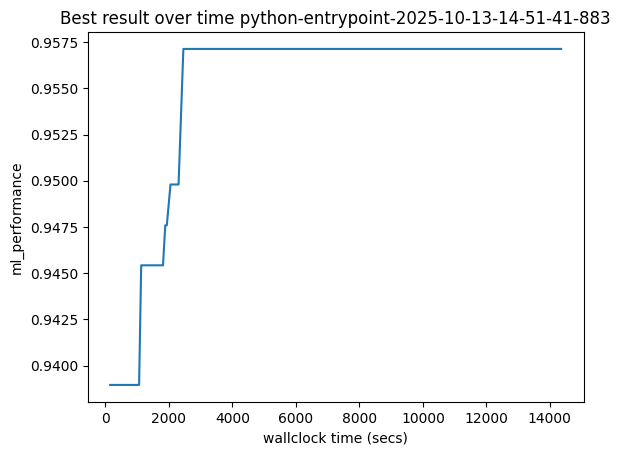

In [12]:
tuning_experiment.plot()

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/syne_tune/experiments/experiment_result.py:177: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


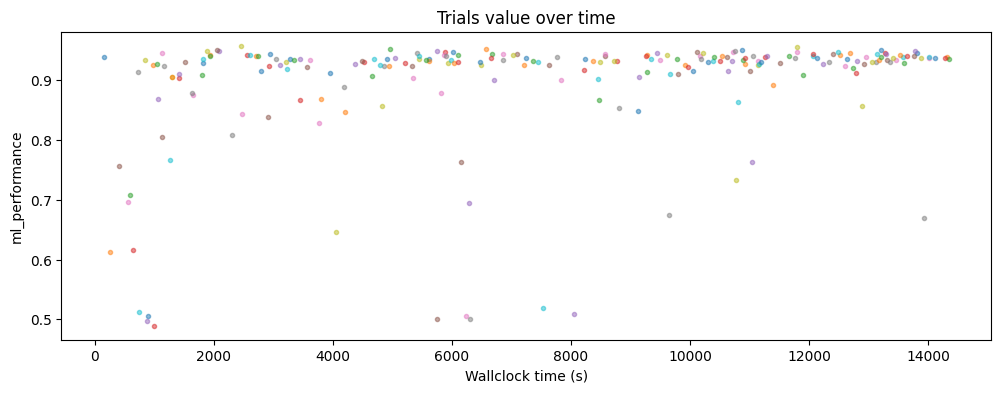

In [13]:
tuning_experiment.plot_trials_over_time()

In [18]:
tuning_experiment.best_config()

{'ml_performance': 0.9571328497156596,
 'recon_loss': 522.1915878690037,
 'trial_id': 38,
 'config_epochs': 200,
 'config_checkpoint_interval': 200,
 'config_loss_reduction': 'sum',
 'config_data_path': './notebooks/large_sc_data/large-ontix-processed-data.pkl',
 'config_ontology_name': 'chatgpt_ontology__',
 'config_tasks': 'cell_type$tissue$development_stage$sex',
 'config_batch_size': 205,
 'config_drop_p': 0.0469544626136819,
 'config_enc_factor': 5,
 'config_weight_decay': 0.0031232088597109,
 'config_beta': 1.3286381420304323e-05,
 'config_learning_rate': 0.0008442939291601,
 'config_n_layers': 3}

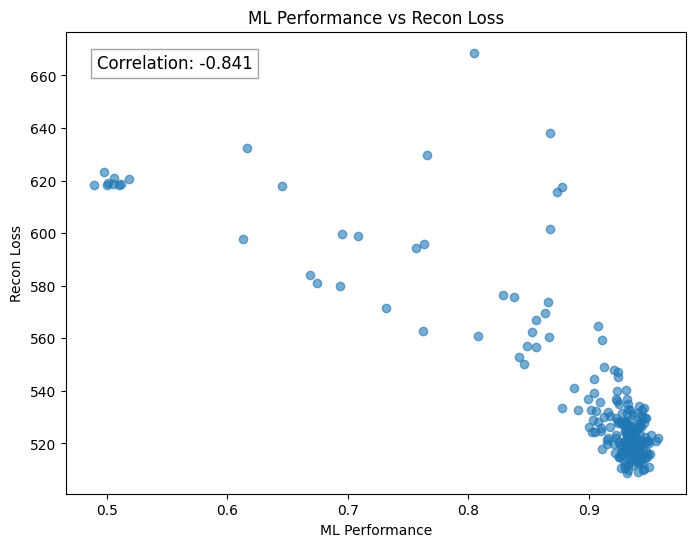

In [17]:
import numpy as np

import matplotlib.pyplot as plt

y = tuning_experiment.results.recon_loss
x = tuning_experiment.results.ml_performance

corr = np.corrcoef(x, y)[0, 1]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.6)
plt.xlabel("ML Performance")
plt.ylabel("Recon Loss")
plt.title("ML Performance vs Recon Loss")
# plt.xlim(0.8, 1.0) ## Limit to good and very good runs
# plt.ylim(500, 600) ##

plt.text(
	0.05, 0.95,
	f"Correlation: {corr:.3f}",
	transform=plt.gca().transAxes,
	fontsize=12,
	verticalalignment='top',
	bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray')
)

plt.show()